In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'subregion_boundaries.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")
print(regions_gdf.crs)
print(rgi_gdf.crs)

ESRI:102025
ESRI:102025


In [4]:
# add the o3region as a column to each rgi
regions_gdf = regions_gdf.rename({"id":"o3region"}, axis=1)
rgi_gdf = rgi_gdf.sjoin(regions_gdf[["o3region","geometry"]])

In [5]:
# for each row, use that glacier's geometry to clip the data and save it as a mask
# but subset by region first, so we avoid constantly opening and closing the regional files
all_regions = np.sort(np.unique(rgi_gdf['o3region'].values))

# open the full velocity product
path_open = os.path.join(folder_datasets, "Velocities", "HMA_120m_mosaic_v_102025.tif")
xr_full_velocity = riox.open_rasterio(path_open, masked=True)

# recast to int (scaled by 100)
xr_full_velocity = xr_full_velocity.where(xr_full_velocity>0, 0).rio.write_crs("ESRI:102025").drop("UTM_Projection")
# xr_full_velocity = xr_full_velocity

In [6]:
c=0
for r in all_regions:
    print("Starting region", r)

    # subset to the rgi in this region
    gdf_susbet = rgi_gdf[rgi_gdf['o3region']==r]
    
    # clip the full velocity file to this region
    region_geom = regions_gdf[regions_gdf['o3region']==r]['geometry'].values[0]
    xr_velocity_clip = xr_full_velocity.rio.clip([region_geom])
    
    for idx, row in gdf_susbet.iterrows():
        c+=1
        # if c>1: continue

        # grab glacier geometry, region, rgiid
        rgi_id = row['rgi_id']
        region = row['o3region']
        geom = row['geometry']
        
        # print progress
        if c%10==0: print(r, c, "of", len(rgi_gdf), rgi_id)
        
        # open glacier mask
        path_mask = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'glacier_mask.tif')
        xr_mask = riox.open_rasterio(path_mask, masked=False).squeeze(drop=True).rename('v')

        # clip the big xr to the rgi geometry (buffered by a little bit)
        xr_clipped = xr_velocity_clip.rio.clip([geom.buffer(200)])
        
        # fill nan with 0
        xr_clipped = xr_clipped.where(~np.isnan(xr_clipped), 0).squeeze(drop=True)
        
        # interpolate to the mask grid
        xr_interp = xr_clipped.interp_like(xr_mask, method='linear', assume_sorted=False)
        xr_interp = xr_interp.where(xr_mask>0, np.nan)

        # save as geotiff
        out_path = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'glacier_velocity.tif')
        xr_interp.rio.to_raster(out_path, compress='LZW', tiled=True)

        # break
    # break

print("All done!")

Starting region 1
Starting region 2
2 10 of 769 RGI2000-v7.0-G-15-17006
Starting region 3
3 20 of 769 RGI2000-v7.0-G-15-14828
Starting region 4
4 30 of 769 RGI2000-v7.0-G-13-69268
4 40 of 769 RGI2000-v7.0-G-13-71532
4 50 of 769 RGI2000-v7.0-G-13-71720
4 60 of 769 RGI2000-v7.0-G-13-73319
4 70 of 769 RGI2000-v7.0-G-15-11613
Starting region 5
5 80 of 769 RGI2000-v7.0-G-15-11027
Starting region 6
6 90 of 769 RGI2000-v7.0-G-15-09295
6 100 of 769 RGI2000-v7.0-G-15-09537
6 110 of 769 RGI2000-v7.0-G-15-10171
Starting region 7
7 120 of 769 RGI2000-v7.0-G-15-06654
7 130 of 769 RGI2000-v7.0-G-15-06827
7 140 of 769 RGI2000-v7.0-G-15-07190
7 150 of 769 RGI2000-v7.0-G-15-07878
7 160 of 769 RGI2000-v7.0-G-15-08080
7 170 of 769 RGI2000-v7.0-G-15-08356
7 180 of 769 RGI2000-v7.0-G-15-08688
Starting region 8
8 190 of 769 RGI2000-v7.0-G-15-04301
8 200 of 769 RGI2000-v7.0-G-15-04937
8 210 of 769 RGI2000-v7.0-G-15-05068
8 220 of 769 RGI2000-v7.0-G-15-05330
8 230 of 769 RGI2000-v7.0-G-15-05619
8 240 of 769 R

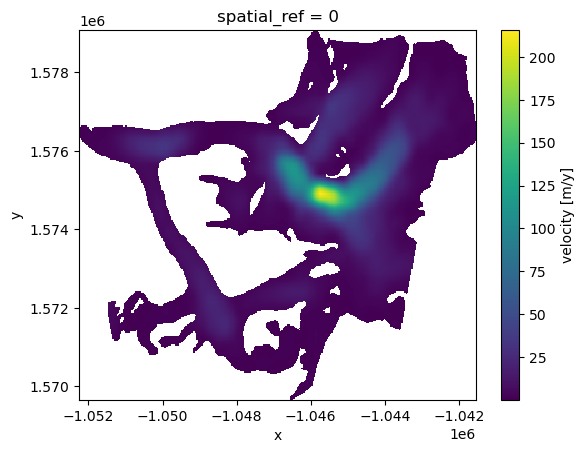

In [7]:
xr_interp.plot()